<a href="https://colab.research.google.com/github/rutvik68/Automated_Resume_Screening_System/blob/main/Automated_Resume_Screening_System_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fake Resume Classification

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
import re

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

In [7]:
from datasets import load_dataset

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
# !pip install --upgrade --force-reinstall nltk

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove email addresses
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove special characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [14]:
import pandas as pd

try:
    df = pd.read_csv("https://huggingface.co/datasets/AzharAli05/Resume-Screening-Dataset/resolve/main/dataset.csv")
    print(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")

                         Role  \
0       E-commerce Specialist   
1              Game Developer   
2  Human Resources Specialist   
3       E-commerce Specialist   
4       E-commerce Specialist   

                                              Resume Decision  \
0  Here's a professional resume for Jason Jones:\...   reject   
1  Here's a professional resume for Ann Marshall:...   select   
2  Here's a professional resume for Patrick Mccla...   reject   
3  Here's a professional resume for Patricia Gray...   select   
4  Here's a professional resume for Amanda Gross:...   reject   

                                 Reason_for_decision  \
0    Lacked leadership skills for a senior position.   
1              Strong technical skills in AI and ML.   
2  Insufficient system design expertise for senio...   
3  Impressive leadership and communication abilit...   
4    Lacked leadership skills for a senior position.   

                                     Job_Description  
0  Be part of a pa

In [15]:
df

,Role,Resume,Decision,Reason_for_decision,Job_Description
0,E-commerce Specialist,Here's a professional resume for Jason Jones:\...,reject,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...
1,Game Developer,Here's a professional resume for Ann Marshall:...,select,Strong technical skills in AI and ML.,Help us build the next-generation products as ...
2,Human Resources Specialist,Here's a professional resume for Patrick Mccla...,reject,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...
3,E-commerce Specialist,Here's a professional resume for Patricia Gray...,select,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...
4,E-commerce Specialist,Here's a professional resume for Amanda Gross:...,reject,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...
...,...,...,...,...,...
10169,Product Manager,Here's a sample resume for Diana Miller:\n\n**...,reject,Unsatisfactory references or background check.,Here is a comprehensive job description for a ...
10170,UI Engineer,Here's a sample resume for Grace Taylor:\n\n**...,reject,Lack of relevant skills or experience.,Here is a sample job description for a UI Engi...
10171,UI Engineer,Here's a sample resume for Hank Brown:\n\n**Ha...,select,Growth mindset and adaptability.,Here is a job description for a UI Engineer ro...
10172,Data Engineer,Here's a sample resume for Diana Wilson:\n\n**...,reject,Lack of relevant skills or experience.,Here is a comprehensive job description for a ...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10174 entries, 0 to 10173
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Role                 10174 non-null  object
 1   Resume               10174 non-null  object
 2   Decision             10174 non-null  object
 3   Reason_for_decision  10174 non-null  object
 4   Job_Description      10174 non-null  object
dtypes: object(5)
memory usage: 397.6+ KB


In [17]:
df.isna().sum()

,0
Role,0
Resume,0
Decision,0
Reason_for_decision,0
Job_Description,0


In [18]:
df['Resume_clean'] = df['Resume'].apply(clean_text)
df['Job_Description_clean'] = df['Job_Description'].apply(clean_text)
df['Reason_for_decision_clean'] = df['Reason_for_decision'].apply(clean_text)

In [19]:
#Value counts on target columns
df['Decision'].value_counts(dropna=False).to_dict()

{'reject': 5114, 'select': 5060}

In [20]:
df['Decision'] = df['Decision'].str.lower().map({'select': 1, 'reject':0}).fillna(0).astype(int)

In [21]:
df['Decision'].value_counts(dropna=False).to_dict()

{0: 5114, 1: 5060}

In [22]:
# Keywords that often appear in rejection reasons for suspicious resumes
FAKE_KEYWORDS = {
    'inconsistent', 'exaggerated', 'unverified', 'false', 'fabricated', 'misleading',
    'overstated', 'questionable', 'unsubstantiated', 'implausible', 'discrepancy',
    'overqualified', 'unrealistic', 'suspicious', 'invalid', 'unreliable',
    'plagiarized', 'manipulated', 'duplicate', 'incoherent', 'mismatched',
    'conflicting', 'fake', 'copied', 'forged', 'not genuine', 'unauthentic',
    'too generic', 'lack of evidence', 'lack of clarity', 'too vague',
    'inflated claims', 'not verifiable', 'dubious', 'poor grammar', 'unexplained gap',
    'buzzword overload', 'template-based', 'incomplete info', 'inaccurate dates',
    'job hopping', 'contradiction', 'missing credentials', 'inconsistency in role'
}

In [23]:
# Resume "buzzwords" that may indicate exaggeration or padding
BUZZWORDS = {
    'expert', 'worldclass', 'leading', 'unparalleled', 'visionary', 'guru',
    'synergy', 'rockstar', 'ninja', 'dynamic', 'strategic', 'revolutionary',
    'topnotch', 'cuttingedge', 'bestinclass', 'go-getter', 'disruptive',
    'proven track record', 'innovative', 'highly skilled', 'results-driven',
    'goal-oriented', 'team player', 'motivated', 'hardworking', 'self-starter',
    'detail-oriented', 'multitasker', 'creative thinker', 'fast learner',
    'passionate', 'excellent communicator', 'problem solver', 'strong work ethic',
    'seasoned professional', 'delivers results', 'driven individual', 'out-of-the-box thinker'
}

In [24]:
def flag_fake_resume(reason_clean, resume_clean, decision):
    if not reason_clean or not resume_clean:
        return 0

    reason_clean = reason_clean.lower()
    resume_clean = resume_clean.lower()

    # Flag if decision is rejection and reason has fake-indicating terms
    if decision == 0:
        if any(keyword in reason_clean for keyword in FAKE_KEYWORDS):
            return 1

    # Tokenize and count buzzwords
    resume_tokens = word_tokenize(resume_clean)
    resume_token_set = set(resume_tokens)

    buzzword_hits = resume_token_set.intersection(BUZZWORDS)
    if len(buzzword_hits) > 3:
        return 1

    return 0

In [25]:
df['is_fake'] = df.apply(lambda x: flag_fake_resume(x['Reason_for_decision_clean'], x['Resume_clean'], x['Decision']), axis=1)

In [26]:
df['is_fake'].value_counts().to_dict()

{0: 10048, 1: 126}

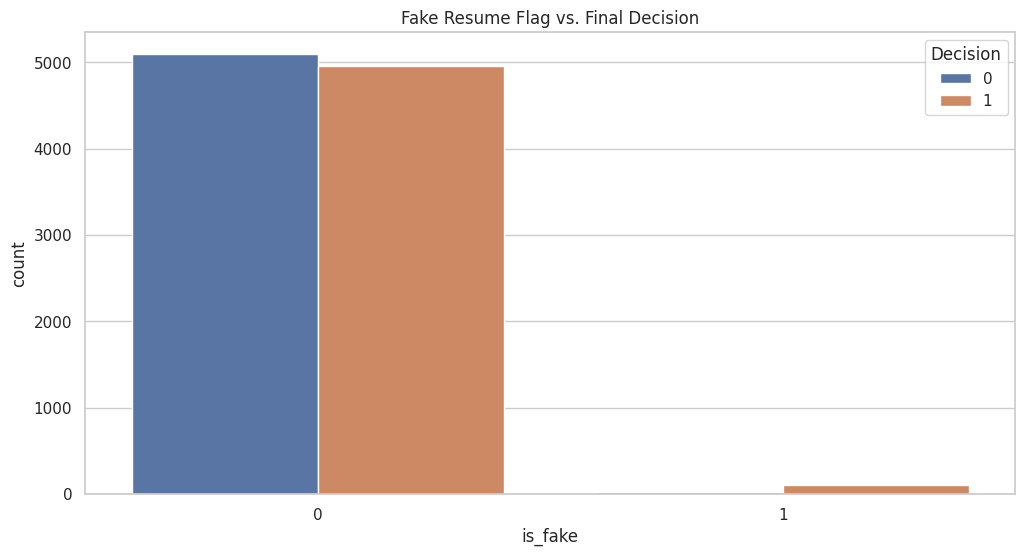

In [27]:
sns.countplot(x='is_fake', hue='Decision', data=df)
plt.title("Fake Resume Flag vs. Final Decision")
plt.show()

In [28]:
large_companies = [
        'Google', 'Amazon', 'Microsoft', 'Meta', 'Apple', 'Tesla', 'Netflix',
        'Adobe', 'Uber', 'Airbnb','Spotify', 'Stripe', 'Dropbox', 'Nvidia',
        'SpaceX', 'OpenAI'
    ]

In [29]:
def generate_fake_resume(original_resume, role):

    #  Randomly select 10 buzzwords to simulate exaggerated claims
    exaggerated_claims = " ".join(np.random.choice(list(BUZZWORDS), size=10, replace=True))

    # Add a fake high-level title at a random top company
    fake_experience = (
        f" Former Chief {role.title()} Officer at {np.random.choice(large_companies)}, "
        f"with over 15 years of experience leading AI-driven, blockchain-enabled, "
        f"cloud-native solutions across global enterprises."
    )

    # Combine original text, buzzwords, and fake experience
    fake_resume = f"{original_resume} {exaggerated_claims} {fake_experience}"

    # Clean the combined text using your NLP pipeline
    return clean_text(fake_resume)

In [30]:
# no. of fake resume generate
n_fake = int(len(df) * 0.5 / (1 - 0.5)) - df['is_fake'].sum()

In [31]:
if n_fake > 0:
    #  Sample resumes to base fake ones on (with replacement)
    fake_resumes = df[['Resume_clean', 'Role']].sample(
        n=n_fake, random_state=42, replace=True
    )

    #  Generate exaggerated fake resumes.
    fake_resumes['Resume_clean'] = fake_resumes.apply(
        lambda x: generate_fake_resume(x['Resume_clean'], x['Role']), axis=1
    )

    # Build a new DataFrame for fake records
    fake_df = pd.DataFrame({
        'Role': fake_resumes['Role'],
        'Resume': fake_resumes['Resume_clean'],
        'Resume_clean': fake_resumes['Resume_clean'],
        'Decision': 0,
        'Reason_for_decision': 'Generated fake resume with exaggerated claims',
        'Reason_for_decision_clean': 'generated fake resume exaggerated claim',

        # Match job descriptions randomly from real data (with replacement)
        'Job_Description': df['Job_Description'].sample(n=n_fake, random_state=42, replace=True).values,
        'Job_Description_clean': df['Job_Description_clean'].sample(n=n_fake, random_state=42, replace=True).values,

        # Mark these as fake
        'is_fake': 1
    })

    # Add fake resumes to the original DataFrame
    df = pd.concat([df, fake_df], ignore_index=True)

In [32]:
df['is_fake'].value_counts().to_dict()

{1: 10174, 0: 10048}

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [34]:
resume_tfidf = tfidf_vectorizer.fit_transform(df['Resume_clean'])
job_tfidf = tfidf_vectorizer.transform(df['Job_Description_clean'])

In [35]:
# Compute cosine similarity for each pair (resume, job)
similarity_scores = [
    cosine_similarity(res_vector, job_vector)[0][0]
    for res_vector, job_vector in zip(resume_tfidf, job_tfidf)
]

In [36]:
df['similarity_score'] = similarity_scores

In [37]:
SIMILARITY_THRESHOLD = 0.25
df.loc[df['similarity_score'] < SIMILARITY_THRESHOLD, 'is_fake'] = 1

<Axes: xlabel='similarity_score', ylabel='Count'>

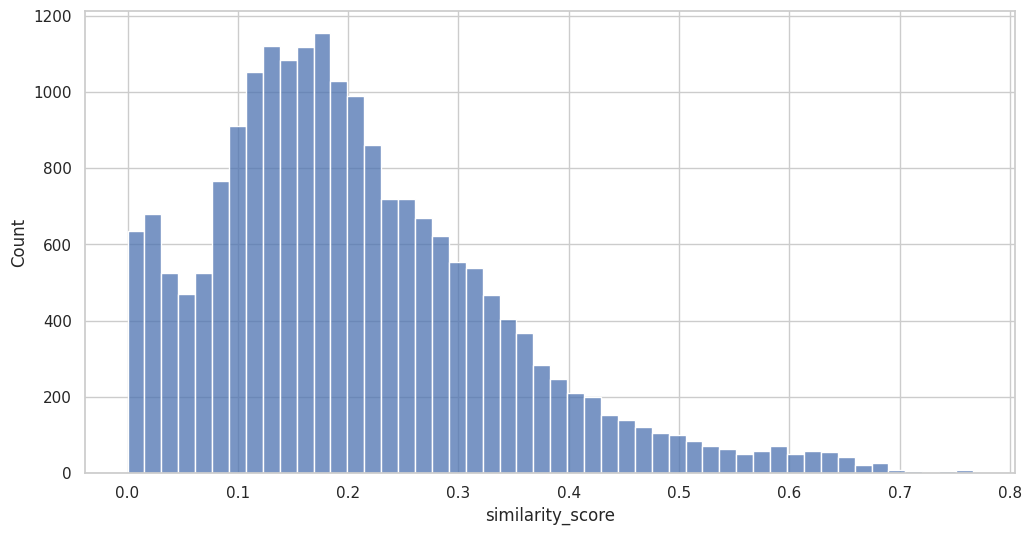

In [38]:
sns.histplot(df['similarity_score'], bins=50)

In [39]:
max_words = 5000
max_len = 50
beads_per_column = 5
tokenizer = Tokenizer(num_words=max_words)

combined_text = df['Resume_clean'] + ' ' + df['Job_Description_clean']

tokenizer.fit_on_texts(combined_text)

X_sequences = tokenizer.texts_to_sequences(combined_text)

# Pad sequences to ensure fixed input size
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

In [40]:
tfidf_abacus = TfidfVectorizer(max_features=max_words, stop_words='english')
combined_text = df['Resume_clean'] + ' ' + df['Job_Description_clean']
X_tfidf = tfidf_abacus.fit_transform(combined_text).toarray()

# Create 3D tensor for 'bead' encoding.
X_abacus = np.zeros((X_padded.shape[0], max_len, beads_per_column))

# Reverse tokenizer index for lookup
word_index = tokenizer.index_word
vocab_lookup = tfidf_abacus.vocabulary_

for i in range(X_padded.shape[0]):
    for t in range(max_len):
        word_idx = X_padded[i, t]

        # Ignore padding (0)
        if word_idx > 0:
            word = word_index.get(word_idx, '')

            if word in vocab_lookup:
                tfidf_idx = vocab_lookup[word]
                tfidf_value = X_tfidf[i, tfidf_idx]

                bead_idx = min(int(tfidf_value * beads_per_column), beads_per_column - 1)

                # One-hot encode in the "bead" column
                X_abacus[i, t, bead_idx] = 1


In [41]:
y_fake = df['is_fake'].values
y_decision = df['Decision'].values


In [42]:
def prepare_balanced_abacus_data(df, label_col, tokenizer, tfidf_vectorizer, max_len, beads_per_column):
    df_0 = df[df[label_col] == 0]
    df_1 = df[df[label_col] == 1]

    if len(df_0) == 0 or len(df_1) == 0:
        print(f"Warning: One class missing in {label_col}. Skipping balancing.")
        X_train, X_test, y_train, y_test = train_test_split(
            X_abacus, df[label_col].values, test_size=0.2, random_state=42
        )
        return X_train, X_test, y_train, y_test

    # Balance the classes by oversampling
    n_majority = max(len(df_0), len(df_1))
    df_0_resampled = resample(df_0, replace=True, n_samples=n_majority, random_state=42) if len(df_0) < n_majority else df_0
    df_1_resampled = resample(df_1, replace=True, n_samples=n_majority, random_state=42) if len(df_1) < n_majority else df_1
    df_balanced = pd.concat([df_0_resampled, df_1_resampled])

    # Prepare sequences and TF-IDF
    combined_text = df_balanced['Resume_clean'] + ' ' + df_balanced['Job_Description_clean']
    sequences = tokenizer.texts_to_sequences(combined_text)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    tfidf_matrix = tfidf_vectorizer.transform(combined_text).toarray()

    # Create 3D abacus input
    abacus = np.zeros((padded.shape[0], max_len, beads_per_column))
    for i in range(padded.shape[0]):
        for t in range(max_len):
            word_idx = padded[i, t]
            if word_idx > 0:
                word = tokenizer.index_word.get(word_idx, '')
                if word in tfidf_vectorizer.vocabulary_:
                    tfidf_idx = tfidf_vectorizer.vocabulary_[word]
                    bead_value = tfidf_matrix[i, tfidf_idx]
                    bead_idx = min(int(bead_value * beads_per_column), beads_per_column - 1)
                    abacus[i, t, bead_idx] = 1

    labels = df_balanced[label_col].values
    return train_test_split(abacus, labels, test_size=0.2, stratify=labels, random_state=42)

In [43]:
# Train/test split for is_fake classification.
X_fake_train, X_fake_test, y_fake_train, y_fake_test = prepare_balanced_abacus_data(df, 'is_fake', tokenizer, tfidf_abacus, max_len, beads_per_column)

In [44]:
# Train/test split for Decision classification.
X_dec_train, X_dec_test, y_dec_train, y_dec_test = prepare_balanced_abacus_data(df, 'Decision', tokenizer, tfidf_abacus, max_len, beads_per_column)

In [45]:
def build_abacus_network(max_len, beads_per_column):
    model = Sequential([
        LSTM(128, input_shape=(max_len, beads_per_column), return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [46]:
# Train and evaluate model for is_fake
if len(np.unique(y_fake_train)) > 1:
    model_fake = build_abacus_network(max_len, beads_per_column)
    model_fake.fit(X_fake_train, y_fake_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

    # Predict and evaluate
    y_fake_pred = (model_fake.predict(X_fake_test) > 0.5).astype(int)
    print("Fake Resume Classification Report:")
    print(classification_report(y_fake_test, y_fake_pred))

    if len(np.unique(y_fake_test)) > 1:
        print("ROC-AUC (Fake):", roc_auc_score(y_fake_test, model_fake.predict(X_fake_test)))
    else:
        print("ROC-AUC (Fake): Skipped due to single class in test set")
else:
    print("Skipping training for is_fake: Only one class present.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5694 - loss: 0.6786 - val_accuracy: 0.6279 - val_loss: 0.6475
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6631 - loss: 0.6266 - val_accuracy: 0.7576 - val_loss: 0.5177
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7619 - loss: 0.5100 - val_accuracy: 0.7843 - val_loss: 0.4769
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7739 - loss: 0.4798 - val_accuracy: 0.7794 - val_loss: 0.4735
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7764 - loss: 0.4684 - val_accuracy: 0.7805 - val_loss: 0.4709
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7844 - loss: 0.4628 - val_accuracy: 0.7958 - val_loss: 0.4499
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7882 - loss: 0.4516 - val_accuracy: 0.7763 - val_loss: 0.4842
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7882 - loss: 0.4622 - val_

In [47]:
# Train and evaluate model for Decision classification
if len(np.unique(y_dec_train)) > 1:
    model_decision = build_abacus_network(max_len, beads_per_column)
    model_decision.fit(X_dec_train, y_dec_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

    # Predict and evaluate
    y_dec_pred = (model_decision.predict(X_dec_test) > 0.5).astype(int)
    print("Selection/Rejection Classification Report:")
    print(classification_report(y_dec_test, y_dec_pred))

    if len(np.unique(y_dec_test)) > 1:
        print("ROC-AUC (Decision):", roc_auc_score(y_dec_test, model_decision.predict(X_dec_test)))
    else:
        print("ROC-AUC (Decision): Skipped due to single class in test set")
else:
    print("Skipping training for Decision: Only one class present.")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


607/607 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5093 - loss: 0.6941 - val_accuracy: 0.4979 - val_loss: 0.6936
Epoch 2/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4957 - loss: 0.6938 - val_accuracy: 0.4965 - val_loss: 0.6937
Epoch 3/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4968 - loss: 0.6937 - val_accuracy: 0.4998 - val_loss: 0.6933
Epoch 4/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5016 - loss: 0.6935 - val_accuracy: 0.4996 - val_loss: 0.6935
Epoch 5/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4979 - loss: 0.6937 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 6/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4964 - loss: 0.6934 - val_accuracy: 0.5074 - val_loss: 0.6929
Epoch 7/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5063 - loss: 0.6933 - val_accuracy: 0.4994 - val_loss: 0.6931
Epoch 8/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5028 - loss: 0.6939 - val_accuracy: 

In [50]:
def visualize_abacus_words(features, title, tokenizer, sample_idx, X_padded):

    plt.figure(figsize=(12, 4))

    bead_positions = features          # Shape: (max_len, beads_per_column)
    word_indices = X_padded[sample_idx]            # Sequence of word indices for this sample
    word_labels = []

    # Limit to first 10 words for clarity
    for t in range(min(10, bead_positions.shape[0])):
        word_idx = word_indices[t]
        word = tokenizer.index_word.get(word_idx, 'PAD') if word_idx > 0 else 'PAD'
        word_labels.append(word)

        # Plot each bead (beads_per_column)
        for row in range(bead_positions.shape[1]):
            color = 'red' if bead_positions[t, row] else 'gray'
            plt.scatter(t, row, c=color, s=100)

    plt.xticks(range(len(word_labels)), word_labels, rotation=45, ha='right')
    plt.yticks(range(bead_positions.shape[1]), [f"Bead {i+1}" for i in range(bead_positions.shape[1])])
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

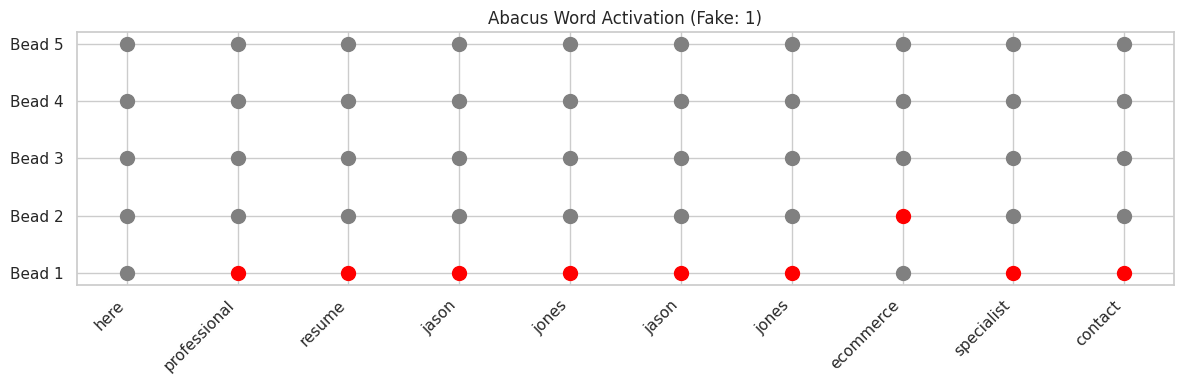

In [51]:
sample_idx = 0

# bead activations for the selected sample — label: is_fake
visualize_abacus_words(
    X_abacus[sample_idx],
    f"Abacus Word Activation (Fake: {y_fake[sample_idx]})",
    tokenizer,
    sample_idx,
    X_padded
)



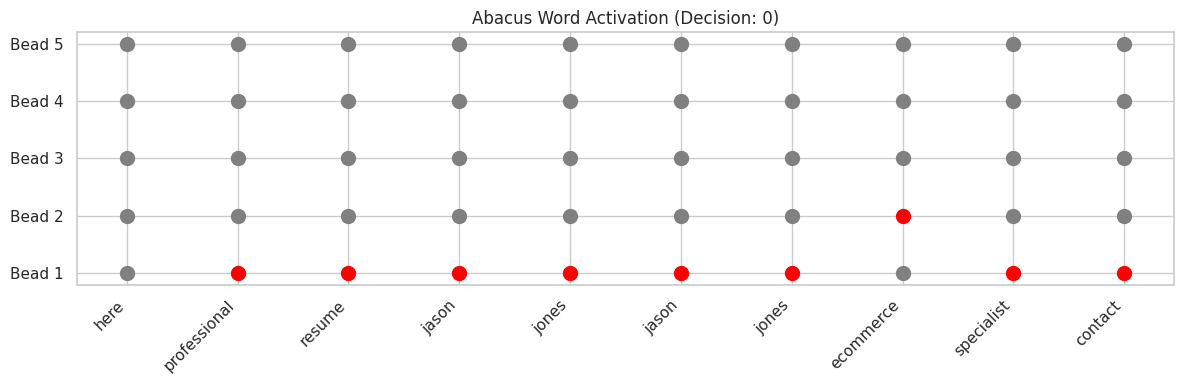

In [52]:
# bead activations for the same sample — label: Decision
visualize_abacus_words(
    X_abacus[sample_idx],
    f"Abacus Word Activation (Decision: {y_decision[sample_idx]})",
    tokenizer,
    sample_idx,
    X_padded
)

In [53]:
# top 10 most frequent roles
top_roles = df['Role'].value_counts().nlargest(10).index
df['Role_plot'] = df['Role'].where(df['Role'].isin(top_roles), 'Other')

In [54]:
# top 10 most common rejection reasons
top_reasons = df['Reason_for_decision'].value_counts().nlargest(10).index
df['Reason_plot'] = df['Reason_for_decision'].where(df['Reason_for_decision'].isin(top_reasons), 'Other')

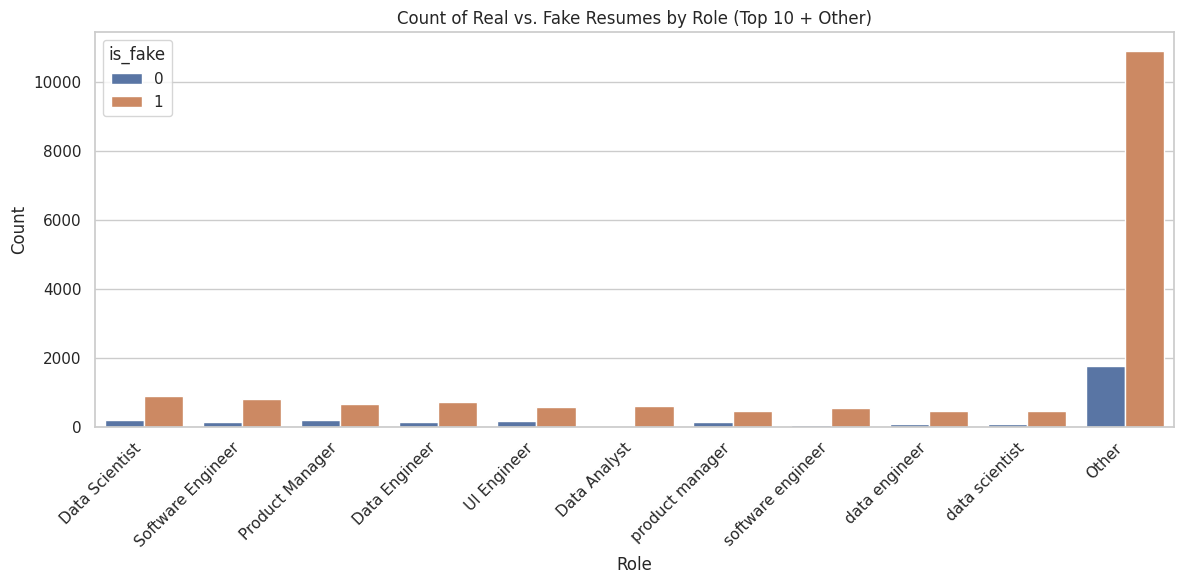

In [55]:
plt.figure()
sns.countplot(data=df, x='Role_plot', hue='is_fake',
order=top_roles.append(pd.Index(['Other'])))
plt.title('Count of Real vs. Fake Resumes by Role (Top 10 + Other)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Role')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

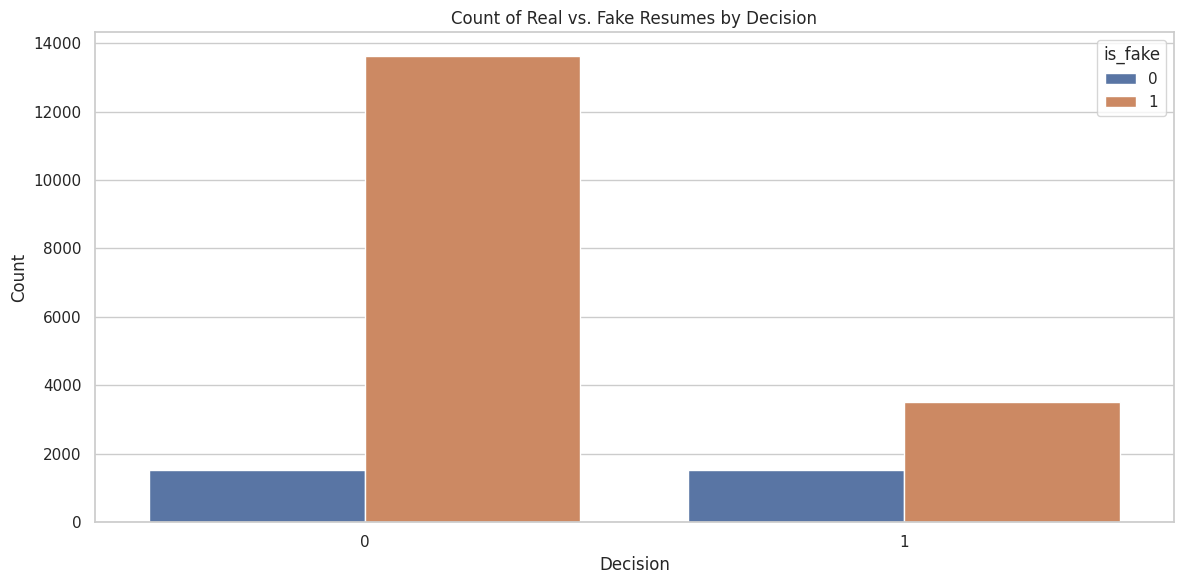

In [56]:
plt.figure()
sns.countplot(data=df, x='Decision', hue='is_fake')
plt.title('Count of Real vs. Fake Resumes by Decision')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

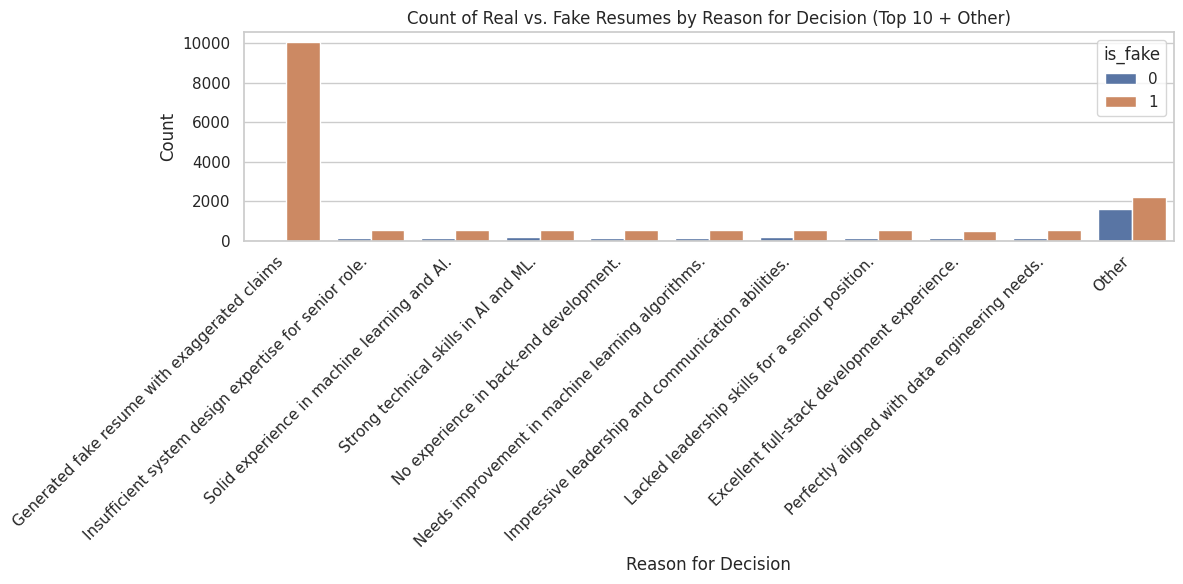

In [58]:
plt.figure()
sns.countplot(data=df, x='Reason_plot', hue='is_fake',
order=top_reasons.append(pd.Index(['Other'])))
plt.title('Count of Real vs. Fake Resumes by Reason for Decision (Top 10 + Other)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Reason for Decision')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

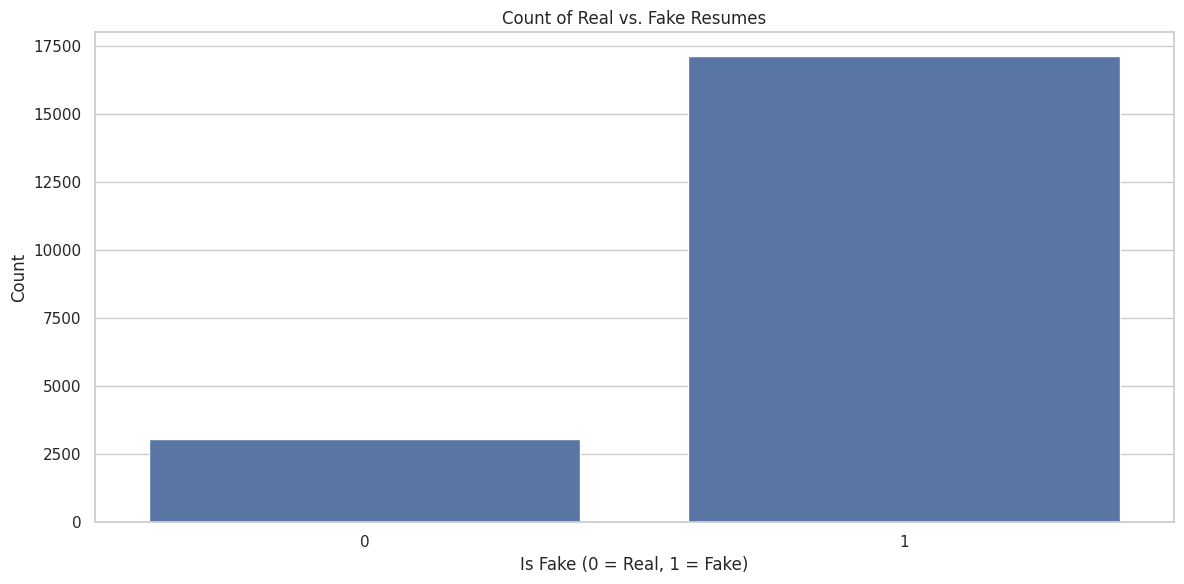

In [59]:
plt.figure()
sns.countplot(data=df, x='is_fake')
plt.title('Count of Real vs. Fake Resumes')
plt.xlabel('Is Fake (0 = Real, 1 = Fake)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


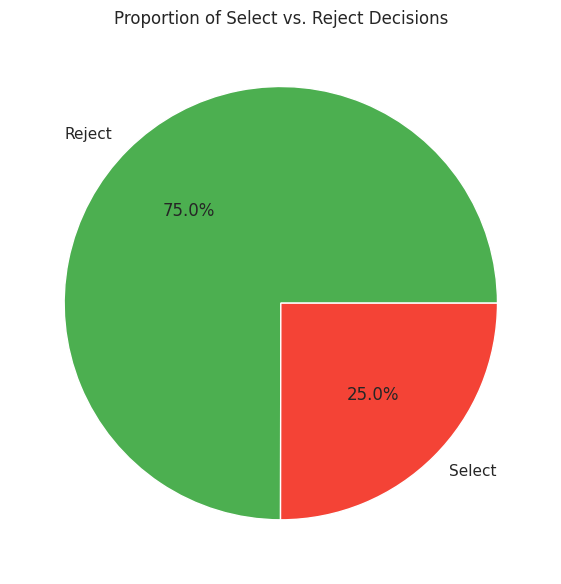

In [60]:
plt.figure()
df['Decision'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#4CAF50',
'#F44336'], labels=['Reject', 'Select'])
plt.title('Proportion of Select vs. Reject Decisions')
plt.ylabel('')
plt.tight_layout()
plt.show()

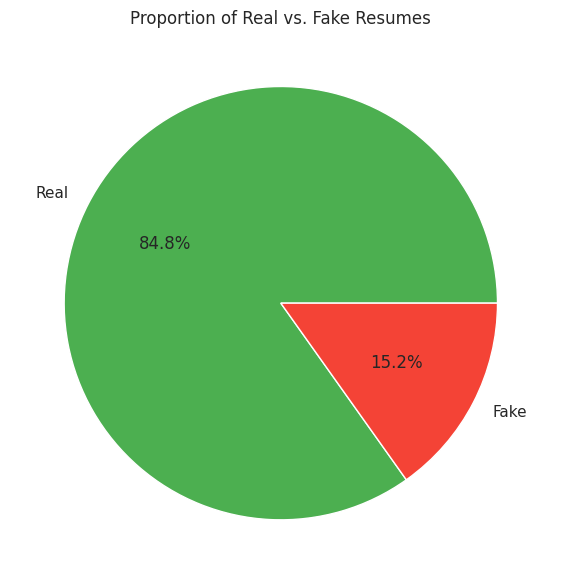

In [61]:
plt.figure()
df['is_fake'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Real',
'Fake'], colors=['#4CAF50', '#F44336'])
plt.title('Proportion of Real vs. Fake Resumes')
plt.ylabel('')
plt.tight_layout()
plt.show()

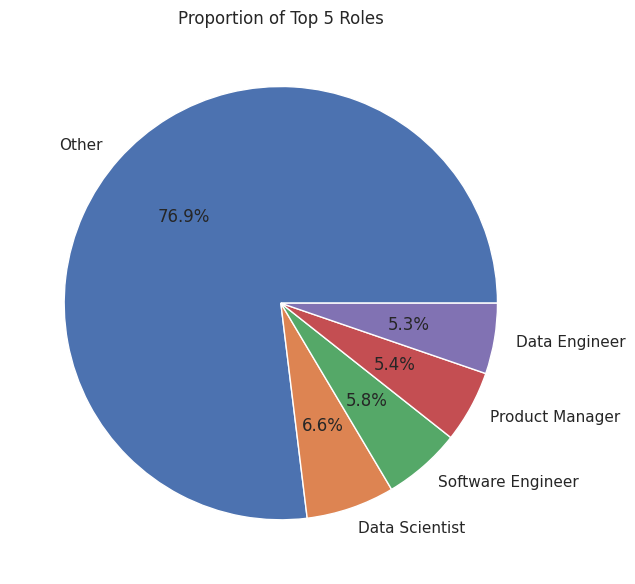

In [62]:
plt.figure()
df['Role_plot'].value_counts().nlargest(5).plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Top 5 Roles')
plt.ylabel('')
plt.tight_layout()
plt.show()

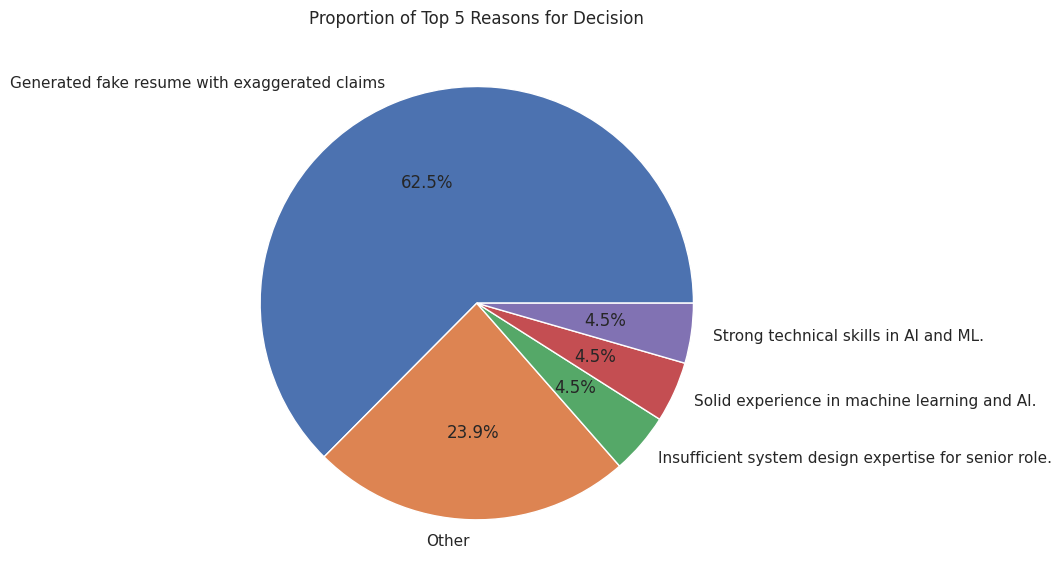

In [63]:
plt.figure()
df['Reason_plot'].value_counts().nlargest(5).plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Top 5 Reasons for Decision')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [65]:
df['resume_word_count'] = df['Resume_clean'].apply(lambda x:len(word_tokenize(str(x))))
df['job_word_count'] = df['Job_Description_clean'].apply(lambda x:len(word_tokenize(str(x))))

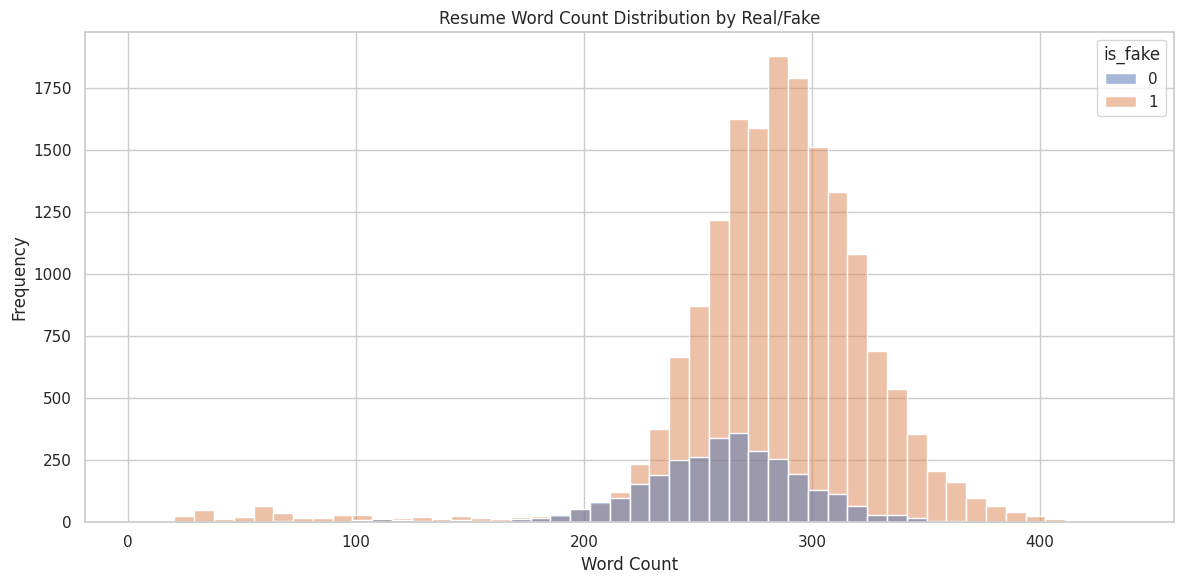

In [66]:
plt.figure()
sns.histplot(data=df, x='resume_word_count', hue='is_fake', bins=50)
plt.title('Resume Word Count Distribution by Real/Fake')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

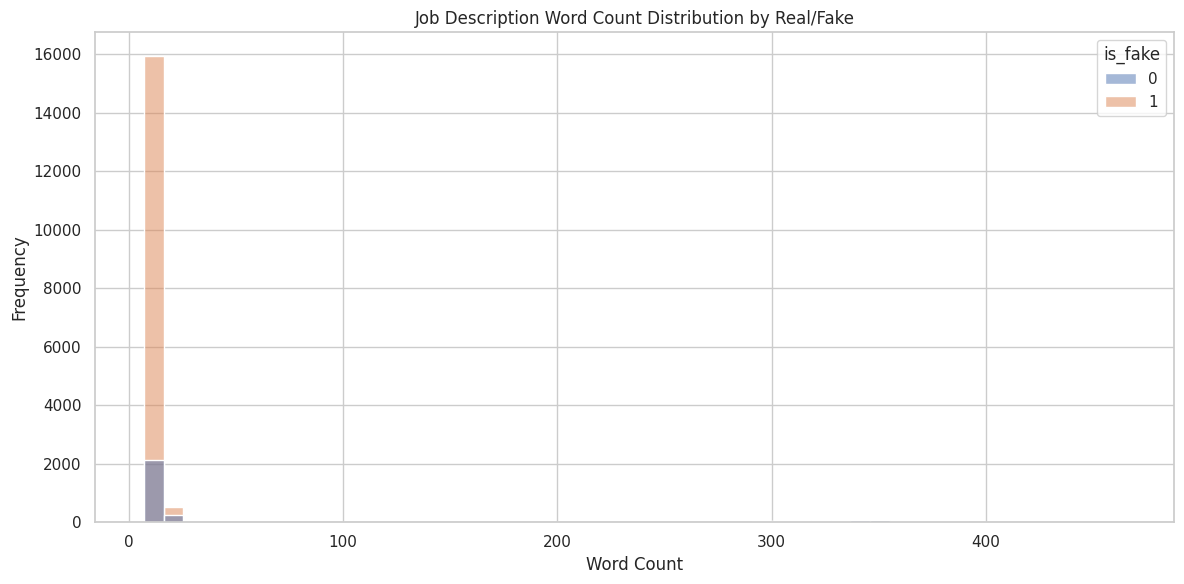

In [67]:
plt.figure()
sns.histplot(data=df, x='job_word_count', hue='is_fake', bins=50)
plt.title('Job Description Word Count Distribution by Real/Fake')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [68]:
def generate_wordcloud(text, title):
 wordcloud = WordCloud(width=800, height=400, background_color='white',max_words=100).generate(text)
 plt.figure()
 plt.imshow(wordcloud, interpolation='bilinear')
 plt.title(title)
 plt.axis('off')
 plt.tight_layout()
 plt.show()

In [70]:
print("is_fake distribution:", df['is_fake'].value_counts().to_dict())
print("Decision distribution:", df['Decision'].value_counts().to_dict())
print("Top 10 Roles:", df['Role'].value_counts().head(10).to_dict())
print("Top 10 Reasons:",
df['Reason_for_decision'].value_counts().head(10).to_dict())
print("is_fake test distribution:",
pd.Series(y_fake_test).value_counts().to_dict())
if len(np.unique(y_dec_test)) > 0:
 print("Decision test distribution:",
pd.Series(y_dec_test).value_counts().to_dict())
else:
 print("Decision test distribution: Empty due to missing classes")

is_fake distribution: {1: 17155, 0: 3067}
Decision distribution: {0: 15162, 1: 5060}
Top 10 Roles: {'Data Scientist': 1085, 'Software Engineer': 956, 'Product Manager': 885, 'Data Engineer': 866, 'UI Engineer': 767, 'Data Analyst': 634, 'product manager': 625, 'software engineer': 610, 'data engineer': 582, 'data scientist': 558}
Top 10 Reasons: {'Generated fake resume with exaggerated claims': 10048, 'Insufficient system design expertise for senior role.': 730, 'Solid experience in machine learning and AI.': 728, 'Strong technical skills in AI and ML.': 718, 'No experience in back-end development.': 717, 'Needs improvement in machine learning algorithms.': 707, 'Impressive leadership and communication abilities.': 704, 'Lacked leadership skills for a senior position.': 685, 'Excellent full-stack development experience.': 677, 'Perfectly aligned with data engineering needs.': 668}
is_fake test distribution: {0: 3431, 1: 3431}
Decision test distribution: {0: 3033, 1: 3032}
